# MAE 598: Design Optimization - Homework 3

## Problem 1

Equilibrium pressure is given by

equilibrium relation can be formulated as:

$$ {p = x_1 \exp\Bigg(A_{12} \ \Big(\frac{A_{21} \ x_2}{A_{12} \ x_1 \ + \ A_{21} \ x_2}\Big)^2\Bigg) \ p^{sat}_{1} \ + \
        x_2 \exp\Bigg(A_{21} \ \Big(\frac{A_{12} \ x_1}{A_{12} \ x_1 \ + \ A_{21} \ x_2}\Big)^2\Bigg) \ p^{sat}_{2}} $$
        
        
Saturation pressure is given by

$$ {\log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3}} $$

$ p^{sat} $ is calculated by rearranging the above expression

$$ { p^{sat} = 10^{\displaystyle\Big(a_1 - \frac{a_2}{T + a_3}\Big)}} $$


Relation between $ x_1 $ and $ x_2 $ is given by

$$ {x_1 + x_2 = 1 } $$

$ x_2 $ caluculated from this expression and the given values of $ x_1 $


The objective function


$$ {\min_{A_{12}, A_{21}} \quad  \displaystyle \sum_{i=1}^{n=11}(p(x_i, A) - p_m)^2 } $$

where,

$ p(x_i, A) $ is the output from the prediction model

$ p_m $ is the measured value

The objective function is modeled using **MSELoss()** method from **torch.nn** module and the gradient descent is performed using **torch.optim.SGD()** (Stochastic Gradient Descent) optimizer in PyTorch.

In [1]:
# Import libraries
import torch as t
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt

In [2]:
# Initialize all given data

T = 20.0 # Temperature in °C

# x1 and x2 values
x1 = t.linspace(0., 1.0, 11, dtype=t.float32)
x2 = 1 - x1

# Measured pressure values
pm = t.tensor([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5], dtype=t.float32)

# Constants a1, a2 and a3
a = t.tensor([[8.07131, 1730.63, 233.426], 
              [7.43155, 1554.679, 240.337]], dtype=t.float32)

In [3]:
# Calculate the saturation pressure
pSat =  lambda a: 10.0 ** (a[0] - (a[1] / (T + a[2])))

pSat1 = pSat(a[0,:]) # Water
pSat2 = pSat(a[1,:]) # 1,4 dioxane
print(f'Saturation pressures \nWater: {pSat1} \n1,4 dioxane: {pSat2} \n')

Saturation pressures 
Water: 17.473241806030273 
1,4 dioxane: 28.82411003112793 



In [4]:
# Define the pressure equilibrium relation
def forward():
    p = lambda A: (x1 * pSat1 * t.exp(A[0] * ((A[1] * x2) / (A[0] * x1 + A[1] * x2)) ** 2)) + (x2 * pSat2 * t.exp(A[1] * ((A[0] * x1) / (A[0] * x1 + A[1] * x2)) ** 2))
    return p(A)

In [16]:
# Define initial parameters
learnig_rate = 0.001
max_iters = 200
A = t.tensor([0.1, 0.1], requires_grad=True) # Optimization variable A12 = A[0], A21 = [1]

# Define MSE loss function
loss = nn.MSELoss(reduction='sum')
# Select Stochastic Gradient Descent as the optimization method
optimizer = t.optim.SGD([A], lr=learnig_rate)

# Train the model
for epochs in range(max_iters):
    p_pred = forward() # Forward pass to calculate the predicted pressure value
    cost = loss(pm, p_pred) # Compute the loss
    
    # Output the training parameters
    if epochs % 10 == 9:
        print(f'epoch; {epochs} \t Loss: {cost} \t A: {A}')

    cost.backward() # Compute the gradient
    optimizer.step() # Compute the next step, update A
    optimizer.zero_grad() # Clear out the current gradient

epoch; 9 	 Loss: 0.9369445443153381 	 A: tensor([1.9045, 1.7355], requires_grad=True)
epoch; 19 	 Loss: 0.6986766457557678 	 A: tensor([1.9405, 1.7041], requires_grad=True)
epoch; 29 	 Loss: 0.6733143925666809 	 A: tensor([1.9525, 1.6941], requires_grad=True)
epoch; 39 	 Loss: 0.6705505847930908 	 A: tensor([1.9564, 1.6908], requires_grad=True)
epoch; 49 	 Loss: 0.6702479124069214 	 A: tensor([1.9578, 1.6897], requires_grad=True)
epoch; 59 	 Loss: 0.6702129244804382 	 A: tensor([1.9582, 1.6894], requires_grad=True)
epoch; 69 	 Loss: 0.6702102422714233 	 A: tensor([1.9583, 1.6892], requires_grad=True)
epoch; 79 	 Loss: 0.6702093482017517 	 A: tensor([1.9584, 1.6892], requires_grad=True)
epoch; 89 	 Loss: 0.6702074408531189 	 A: tensor([1.9584, 1.6892], requires_grad=True)
epoch; 99 	 Loss: 0.6702079176902771 	 A: tensor([1.9584, 1.6892], requires_grad=True)
epoch; 109 	 Loss: 0.6702081561088562 	 A: tensor([1.9584, 1.6892], requires_grad=True)
epoch; 119 	 Loss: 0.6702081561088562 	 A: 

In [17]:
# Output results
print("Predicted pressure values:\n", p_pred.detach().numpy())
print(f"\nOptimized values of A \nA12: {A[0].item()} \t A21: {A[1].item()}")

Predicted pressure values:
 [28.82411  34.644318 36.452972 36.867317 36.874012 36.749836 36.39045
 35.38482  32.94778  27.729994 17.473242]

Optimized values of A 
A12: 1.958418369293213 	 A21: 1.6891862154006958


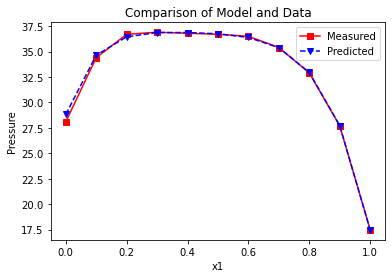

In [18]:
# Plot results
plt.plot(x1, pm, 'rs-', label="Measured")
plt.plot(x1, p_pred.detach().numpy(), 'bv--', label="Predicted")
plt.xlabel('x1')
plt.ylabel('Pressure')
plt.title('Comparison of Model and Data')
plt.legend()
plt.show()

## Problem 2

Objective function


$$ {\min_{x_{1}, x_{2}} \quad  \Big(4 - 2.1 x^2_1 + \frac{x^4_1}{3}\Big) \ x^2_1 + x_1 x_2 + (-4 + 4 x^2_2) \ x^2_2 } $$

In [21]:
# Import libraries
import numpy as np
import sklearn
from matplotlib import pyplot as plt